In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import sys
import os
import psycopg2 as psy
from psycopg2 import sql
from io import StringIO
import sqlalchemy
from sqlalchemy import create_engine
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")
import mtg_helpers as mtgh
import scipy.stats as stats


con_details = {"dbname" : 'pay_to_play', 
               "user" : os.environ['PGSQL_P_USER'], 
               "password" : os.environ['PGSQL_P_PWD'], 
               "host" : 'localhost'} 


In [266]:
conn = mtgh.connect(con_details)

Connecting to PostgreSQL database...
Connection successful


### Let's start by exploring quickly the total card set data

In [267]:
query = sql.SQL(
    """SELECT 
            core.uuid, core.name, core.rarity, core."setCode", core."keywords", core."convertedManaCost", 
            core.type, core.power, core.toughness, core.subtypes, core.supertypes, 
            setdetails.setname, setdetails.setreleasedate, fixed_prices.price, fixed_prices."price_date"
    FROM core
    LEFT JOIN fixed_prices ON core.uuid = fixed_prices.uuid
    JOIN setdetails  ON core."setCode" = setdetails.setcode""")
card_df = pd.read_sql(query, conn)

In [268]:
card_df.describe()

,convertedManaCost,price
count,3705.000000,3536.000000
mean,3.043185,1.819762
std,1.841967,4.962194
min,0.000000,0.150000
25%,2.000000,0.250000
50%,3.000000,0.250000
75%,4.000000,0.990000
max,12.000000,109.990000


### This gives a nice view to the ranges of price and converted mana cost across all the cards in this analysis.

In [269]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3705 entries, 0 to 3704
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uuid               3705 non-null   object 
 1   name               3705 non-null   object 
 2   rarity             3705 non-null   object 
 3   setCode            3705 non-null   object 
 4   keywords           1521 non-null   object 
 5   convertedManaCost  3705 non-null   float64
 6   type               3705 non-null   object 
 7   power              1850 non-null   object 
 8   toughness          1850 non-null   object 
 9   subtypes           3705 non-null   object 
 10  supertypes         3705 non-null   object 
 11  setname            3705 non-null   object 
 12  setreleasedate     3705 non-null   object 
 13  price              3536 non-null   float64
 14  price_date         3536 non-null   object 
dtypes: float64(2), object(13)
memory usage: 434.3+ KB


### Initial sense of the completness of each key column for potential analysis. Some 'gaps' are expected/explainable in that keywords, power, and toughness tend to only apply to creature-types and thus a ~50% null rate is to be expected.  Because of either the inherent nature of the data or custom behavior on some MTG cards, there are very few fields that can be of numeric types.  Of note would be the power and toughness columns as for creatures these are typically integers except for some creatures that have variable values based on the state of the game and are represented as asterisks.  Can still do numerical analysis on these fields by limiting to just those values with pre-defined integer values and casting to int type.  Biggest 'issue' will ultimately be around the ~150 cards that didn't have prices available from the target price source.

### Ultimately wanting to test our hypothesis that the world champion decks do not cost more than other successful, but amateur, decks.  So let's now look quickly at our deck data.

In [270]:
query = sql.SQL(
    """SELECT decklists.deckname, core.uuid, core.name, 
    decklists.card_count, decklists.sideboard, core.rarity, 
    core."setCode", core."keywords", core."convertedManaCost", 
    core.type, core.power, core.toughness, core.subtypes, core.colors, core."manaCost", core.supertypes, 
    setdetails.setname, setdetails.setreleasedate, fixed_prices.price, fixed_prices."price_date"
FROM core
LEFT JOIN fixed_prices ON core.uuid = fixed_prices.uuid
JOIN setdetails  ON core."setCode" = setdetails.setcode
JOIN decklists ON core.uuid = decklists.uuid""")
decks_df = pd.read_sql(query, conn)

In [271]:
decks_df.describe()

,card_count,convertedManaCost,price
count,1144.000000,1144.000000,1060.000000
mean,2.890734,2.311189,4.218528
std,1.968106,1.908038,7.551366
min,1.000000,0.000000,0.150000
25%,2.000000,1.000000,0.250000
50%,3.000000,2.000000,0.990000
75%,4.000000,3.000000,4.615000
max,20.000000,9.000000,64.990000


In [272]:
decks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   deckname           1144 non-null   object 
 1   uuid               1144 non-null   object 
 2   name               1144 non-null   object 
 3   card_count         1144 non-null   int64  
 4   sideboard          1144 non-null   bool   
 5   rarity             1144 non-null   object 
 6   setCode            1144 non-null   object 
 7   keywords           377 non-null    object 
 8   convertedManaCost  1144 non-null   float64
 9   type               1144 non-null   object 
 10  power              320 non-null    object 
 11  toughness          320 non-null    object 
 12  subtypes           1144 non-null   object 
 13  colors             1144 non-null   object 
 14  manaCost           845 non-null    object 
 15  supertypes         1144 non-null   object 
 16  setname            1144 

### Unfortunately, the decision to limit pricing to a single source prevented complete acquisition of price data for each card.  Need to explore the perspective of deck data that only has prices and decide on an approach for moving forward.  Will compile a deck-based df that breaks out core vs. sideboard cards  and show card counts, total prices, and avg. price per card in each category.


In [134]:
price_only = decks_df.loc[pd.notnull(decks_df['price']), ['deckname', 'card_count', 'price', 'sideboard']]
price_only['total_card_price'] = price_only['card_count'] * price_only['price']
price_only.head()

,deckname,card_count,price,sideboard,total_card_price
0,Platinum-Mythic-Rank-Player-Traditional-(Bo3)(19),4,0.25,False,1.00
1,Platinum-Mythic-Rank-Player-Traditional-(Bo3)(1),3,0.25,True,0.75
2,Ondřej-Stráský-Azorius-Control-Magic-World-Cha...,2,0.25,True,0.50
3,Paulo-Vitor-Damo-da-Rosa-Azorius-Control-Magic...,2,0.25,True,0.50
4,Matias-Leveratto-Temur-Reclamation-Magic-World...,3,0.39,True,1.17


In [135]:
core_price_only = price_only.loc[price_only['sideboard'] == False,:]
core_deck_prices = core_price_only.loc[:,['deckname', 'card_count', 'total_card_price']].groupby('deckname').sum()
core_deck_prices['core_avg_card_price'] = core_deck_prices['total_card_price'] / core_deck_prices['card_count']
#core_deck_prices.rename(columns = {})
core_deck_prices.rename(columns = {'card_count':'core_card_count','total_card_price':'core_deck_price'}, inplace = True)


sboard_price_only = price_only.loc[price_only['sideboard'] == True,:]
sboard_deck_prices = sboard_price_only.loc[:,['deckname', 'card_count', 'total_card_price']].groupby('deckname').sum()
sboard_deck_prices['sboard_avg_card_price'] = sboard_deck_prices['total_card_price'] / sboard_deck_prices['card_count']
sboard_deck_prices.rename(columns = {})
sboard_deck_prices.rename(columns = {'card_count':'sboard_card_count','total_card_price':'sboard_deck_price'}, inplace = True)

deck_prices = core_deck_prices.merge(sboard_deck_prices,how='inner',on='deckname').reset_index()
deck_prices.head()
deck_prices['world_comp'] = deck_prices['deckname'].apply(lambda x: x[:8] != 'Platinum')
deck_prices.tail()

,deckname,core_card_count,core_deck_price,core_avg_card_price,sboard_card_count,sboard_deck_price,sboard_avg_card_price,world_comp
39,Platinum-Mythic-Rank-Player-Traditional-(Bo3)(9),59,250.35,4.243220,15,98.45,6.563333,False
40,Raphaël-Lévy-Jeskai-Fires-Magic-World-Champion...,57,313.59,5.501579,14,39.66,2.832857,True
41,Sebastián-Pozzo-Mono-Red-Aggro-Magic-World-Cha...,56,147.44,2.632857,15,6.87,0.458000,True
42,Seth-Manfield-Mono-Red-Aggro-Magic-World-Champ...,56,130.60,2.332143,15,5.23,0.348667,True
43,Thoralf-Severin-Azorius-Control-Magic-World-Ch...,60,238.76,3.979333,15,13.59,0.906000,True


In [136]:
deck_prices.describe()

,core_card_count,core_deck_price,core_avg_card_price,sboard_card_count,sboard_deck_price,sboard_avg_card_price
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,51.659091,226.635227,4.503797,18.159091,46.366591,2.218371
std,14.496099,119.153386,2.563019,12.970348,80.441338,1.968854
min,1.000000,0.390000,0.390000,11.000000,5.230000,0.348667
25%,51.750000,141.425000,2.611726,15.000000,11.555000,0.770333
50%,56.000000,221.665000,4.046095,15.000000,26.490000,1.746000
75%,59.000000,312.352500,5.538869,15.000000,41.150000,2.840525
max,60.000000,445.140000,13.990000,68.000000,509.980000,8.499667


In [137]:
deck_prices[['deckname', 'world_comp']].groupby('world_comp').count()

,deckname
world_comp,
False,28
True,16


In [138]:
def overlayed_hists(axes, df, series, categories, bins, xlab, ylab, density=False, cumulative=False, leave_open=True):
    """
    Parameters:
        df = dataframe
            Contains the data series (as identified by series parameter) to be plotted on the same graph for a given category.
        series = dict
        categories = array
            array listing the unique categories to filter by graph.
    """
    fsize = 10
    category_field = categories['category']
    for i, cat in enumerate(list(categories.keys())[1:]):
#         for line, label in series.items():
#             axes[i].hist(df.loc[df[category_field] == cat,line], label = label, alpha =.8, bins = bins)
        axes[i].hist(df.loc[df[category_field] == cat,series.keys()], label = list(series.values()), 
                     alpha =.7, bins = bins, density = density, cumulative = cumulative)
        axes[i].set_title(categories[cat])
        axes[i].set_ylabel(ylab, fontsize = fsize)
        axes[i].set_xlabel(xlab, fontsize = fsize)
        axes[i].legend()
        
    fig.tight_layout()
    if leave_open == False:
        plt.show()


    
    

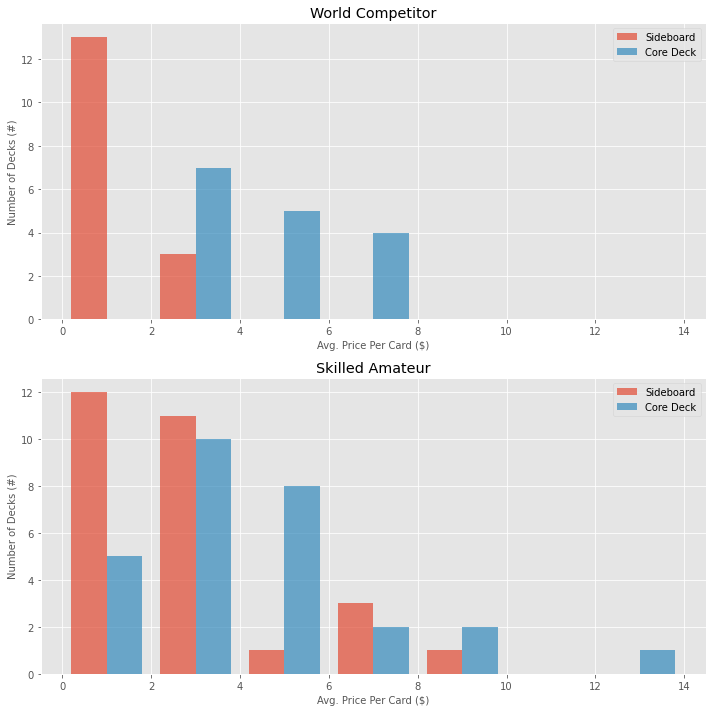

In [139]:
categories = {'category': 'world_comp', True: 'World Competitor', False:'Skilled Amateur'}
series = {'sboard_avg_card_price':'Sideboard', 'core_avg_card_price':'Core Deck'}
x = 'Avg. Price Per Card ($)'
y = 'Number of Decks (#)'
bins = list(range(0,15,2))

fig, axes = plt.subplots(len(categories)-1, figsize=(10,10))
overlayed_hists(axes, deck_prices, series, categories, bins, x, y)






In [140]:
def box_plots(axes, df, series, categories, xlab, ylab, xrange):
    """
    Parameters:
        df = dataframe
            Contains the data series (as identified by series parameter) to be plotted on the same graph for a given category.
        series = dict
        categories = dict
            filter graph and data
    """
    fsize = 10
    category_field = categories['category']
    for i, cat in enumerate(list(categories.keys())[1:]):
        #for box, label in series.items():
        axes[i].boxplot(df.loc[df[category_field] == cat,series.keys()], labels = series.values(), vert = False)
        axes[i].set_title(categories[cat])
        axes[i].set_xlabel(xlab, fontsize = fsize)
        axes[i].set_xlim([xrange[0], xrange[-1]+1])    
    fig.tight_layout()
    plt.show()

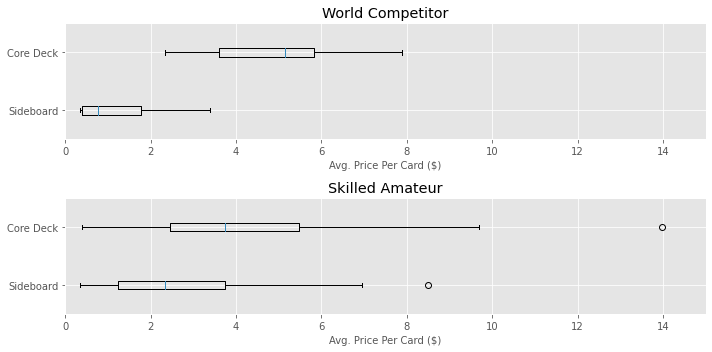

In [141]:
fig, axes = plt.subplots(len(categories)-1, figsize=(10,5))
box_plots(axes, deck_prices, series, categories, x, y, bins)

In [142]:
# Then plot the distributions of each select deck pricing group to compare the two.
# then do hypothesis test.
# ideally some scatters between price and other variables to see any kind of trend... and then pick sample from 
#core cards to create 'at random deck' to see what would generate.

### Initial review of these avg. price per card distributions indicates that the sideboards are not equivalent distributions relative to the core deck cards and as such, random sampling from the sideboard to 'fill' the spaces of the cards that are missing prices in the core deck is probably not a valid approach.  Now let's explore the card counts per deck to assess a reasonable 'cutoff' point for analysis.

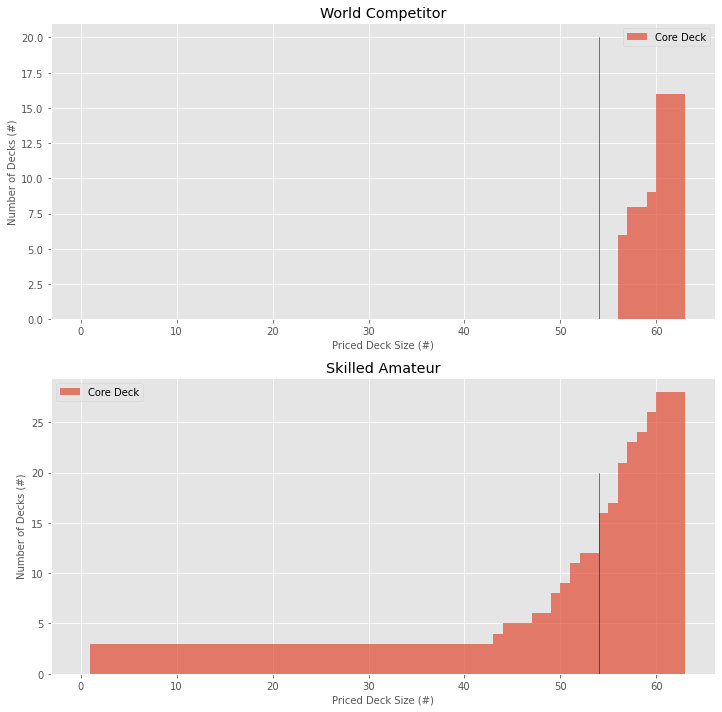

In [143]:
categories = {'category': 'world_comp', True: 'World Competitor', False:'Skilled Amateur'}
series = {'core_card_count':'Core Deck'}
x = 'Priced Deck Size (#)'
y = 'Number of Decks (#)'
bins = list(range(deck_prices['core_card_count'].max()+4))

fig, axes = plt.subplots(len(categories)-1, figsize=(10,10))
overlayed_hists(axes, deck_prices, series, categories, bins, x, y, density=False, cumulative=True, leave_open = True)
#x = [deck_prices.loc[deck_prices['world_comp'] == True, 'core_card_count'].min()]*2
x = [54,54]
y = [0, 20]
x2 = [0, 65]
y2 = [16, 16]


for ax in axes:
    ax.plot(x, y, color = 'k', linewidth = .5)
    #ax.plot(x2,y2, color = 'k', linewidth = .5)
plt.show()


In [144]:
deck_prices[['deckname', 'world_comp']].groupby('world_comp').count()

,deckname
world_comp,
False,28
True,16


### Given the above, going to just set the cutoff to card counts such that we have equal sample size between the world competitors and skilled amateurs. 

In [145]:
deck_prices.loc[deck_prices['core_card_count'] >= 54,['world_comp', 'deckname']].groupby('world_comp').count()

,deckname
world_comp,
False,16
True,16


In [146]:
world_prices = deck_prices.loc[deck_prices['world_comp'] == True, 'core_avg_card_price']
skldam_prices = deck_prices.loc[(deck_prices['world_comp'] == False) & (deck_prices['core_card_count'] >= 54), 'core_avg_card_price']

In [147]:
print(world_prices.count())
world_prices.head()


16


0    2.332143
1    7.577143
2    7.877857
3    2.548333
4    5.501579
Name: core_avg_card_price, dtype: float64

In [148]:
print(skldam_prices.count())
skldam_prices.head()


16


14    2.462500
15    2.766610
17    2.810345
20    3.173158
23    1.997037
Name: core_avg_card_price, dtype: float64

### Based on the histograms above, it does not look like the two card deck categories are from similar distributions nor of normal distributions.  Because of sample size, also can't apply the central limit theorem so will move forward with a MannWhitney U test.

In [149]:
print(stats.mannwhitneyu(world_prices, skldam_prices, alternative = 'greater'))


MannwhitneyuResult(statistic=181.0, pvalue=0.02388583647666761)


### given the p value of .0239, we can reject the null hypothesis and state that the avg. card price for the world champion decks is in fact greater than that of the skilled amateur decks.  

In [150]:
decks_df.loc[pd.notnull(decks_df['price'])]
from string import punctuation, digits

In [174]:
def color_counts(manacosts):
    """intake str remove punctuation, lowercase it, tabulate counts into dictionary by color
    """
    
    colors = {'w':0, 'b':0, 'g':0, 'r':0, 'u':0}
    removals = punctuation + digits + 'x'
    if manacosts is not None:
        rawcosts = [c for c in manacosts.lower() if c not in removals]
        for color in rawcosts:
            colors[color] += 1
    return colors
    
decks_df['colors_counts']= decks_df['manaCost'].apply(color_counts)
    
    
    
    


In [175]:
decks_df[['White','Black', 'Green', 'Red', 'Blue']] = pd.DataFrame(decks_df['colors_counts'].tolist(), index= decks_df.index)
devotion_df = decks_df.loc[decks_df['sideboard'] == False,['deckname', 'card_count','White','Black', 'Green', 'Red', 'Blue']]



In [176]:
devotion_df.info()

#decks_df['devotion'] = decks_df[['White','Black', 'Green', 'Red', 'Blue' ]].idxmax(axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 1143
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   deckname    763 non-null    object
 1   card_count  763 non-null    int64 
 2   White       763 non-null    int64 
 3   Black       763 non-null    int64 
 4   Green       763 non-null    int64 
 5   Red         763 non-null    int64 
 6   Blue        763 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 47.7+ KB


In [177]:

devotion_df.head()

,deckname,card_count,White,Black,Green,Red,Blue
0,Platinum-Mythic-Rank-Player-Traditional-(Bo3)(19),4,1,0,0,0,0
8,Márcio-Carvalho-Jeskai-Fires-Magic-World-Champ...,2,0,0,0,0,1
13,Javier-Dominguez-Jeskai-Fires-Magic-World-Cham...,2,0,0,0,0,1
15,Platinum-Mythic-Rank-Player-Traditional-(Bo3)(21),2,1,0,1,0,0
19,Platinum-Mythic-Rank-Player-Traditional-(Bo3)(12),4,1,0,0,0,0


In [181]:
devotion_df.loc[:,['White','Black', 'Green', 'Red', 'Blue']] = devotion_df.loc[:,['White','Black', 'Green', 'Red', 'Blue']].multiply(devotion_df.loc[:,'card_count'],axis = 'index')
devotion_df = devotion_df.groupby('deckname').sum()

In [240]:
devotion_df['dev_mono'] = devotion_df[['White','Black', 'Green', 'Red', 'Blue']].idxmax('columns')
deck_dev = devotion_df.merge(deck_prices, how = 'inner', on='deckname').sort_values('dev_mono')

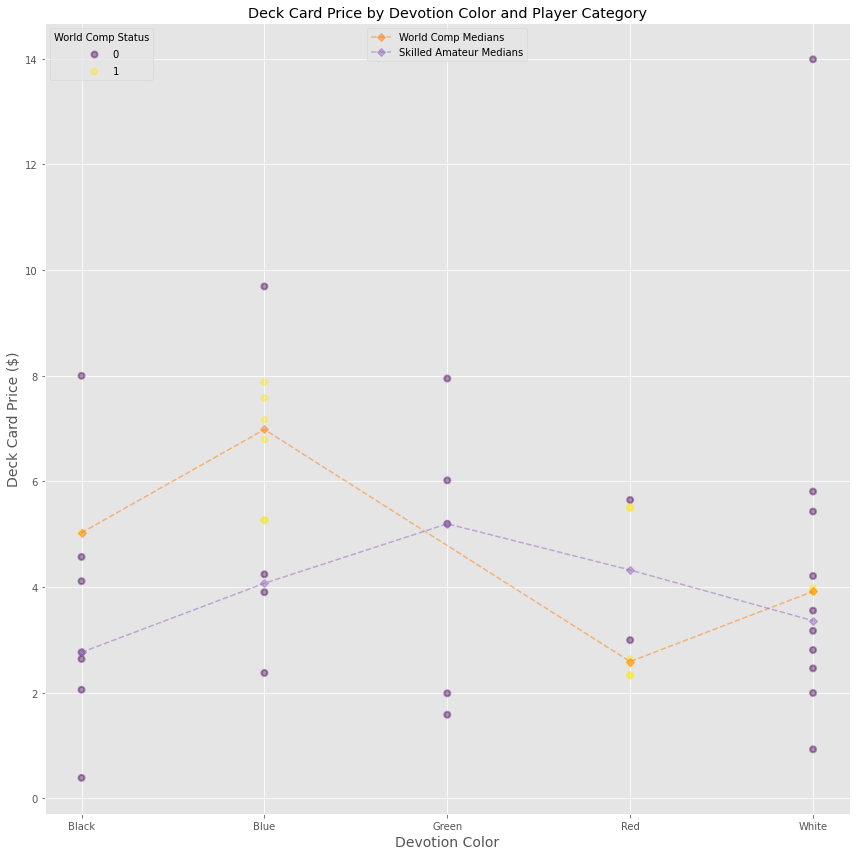

In [263]:
fig, ax = plt.subplots(figsize = (12,12))

scatter = ax.scatter(x = deck_dev['dev_mono'], y = deck_dev['core_avg_card_price'], c = deck_dev['world_comp'] , linewidths = 2, edgecolors = 'face',alpha = .4)
ax.set_title('Deck Card Price by Devotion Color and Player Category')
ax.set_ylabel('Deck Card Price ($)', fontsize = 14)
ax.set_xlabel('Devotion Color', fontsize = 14)
legend1 = ax.legend(*scatter.legend_elements(),title = 'World Comp Status')
ax.add_artist(legend1)

medians = deck_dev[['dev_mono', 'core_avg_card_price', 'world_comp']].groupby(['dev_mono', 'world_comp']).median().reset_index()
world_comp = medians[medians['world_comp'] == True]
skill_a = medians[medians['world_comp'] == False]
plot1 = ax.plot(world_comp['dev_mono'], world_comp['core_avg_card_price'], linestyle='--', color = 'tab:orange',
                alpha = .5, marker = 'D', label = 'World Comp Medians', )
plot2 = ax.plot(skill_a['dev_mono'], skill_a['core_avg_card_price'], linestyle='--', color = 'tab:purple', 
                alpha = .5, marker = 'D', label = 'Skilled Amateur Medians')


ax.legend(loc = 'upper center')
fig.tight_layout()

In [224]:
deck_dev.head()

,deckname,card_count,White,Black,Green,Red,Blue,dev_mono,core_card_count,core_deck_price,core_avg_card_price,sboard_card_count,sboard_deck_price,sboard_avg_card_price,world_comp
0,Andrea-Mengucci-Mono-Red-Aggro-Magic-World-Cha...,60,0,0,0,51,0,Red,56,130.60,2.332143,15,5.23,0.348667,True
1,Autumn-Burchett-Temur-Reclamation-Magic-World-...,60,0,0,13,15,33,Blue,56,424.32,7.577143,15,5.79,0.386000,True
2,Chris-Kvartek-Temur-Reclamation-Magic-World-Ch...,60,0,0,21,8,33,Blue,56,441.16,7.877857,15,6.47,0.431333,True
3,Eli-Loveman-Mono-Red-Aggro-Magic-World-Champio...,60,0,0,0,53,0,Red,60,152.90,2.548333,15,5.33,0.355333,True
4,Gabriel-Nassif-Jeskai-Fires-Magic-World-Champi...,60,11,0,0,24,17,Red,57,313.59,5.501579,14,39.66,2.832857,True


In [273]:
card_df.head()

,uuid,name,rarity,setCode,keywords,convertedManaCost,type,power,toughness,subtypes,supertypes,setname,setreleasedate,price,price_date
0,043fe0a6-9b4d-53fa-8a70-822ac47c7c1e,"Ugin, the Spirit Dragon",mythic,M21,None,8.0,Legendary Planeswalker — Ugin,None,None,[Ugin],[Legendary],Core Set 2021,2020-07-03,25.99,2020-12-15
1,3e14f46a-b9a6-518b-9160-f88b40ad409c,Alpine Watchdog,common,M21,[Vigilance],2.0,Creature — Dog,2,2,[Dog],[],Core Set 2021,2020-07-03,0.25,2020-12-15
2,5cb931df-3664-5562-a74d-6ee5158ab980,Angelic Ascension,uncommon,M21,None,2.0,Instant,None,None,[],[],Core Set 2021,2020-07-03,0.25,2020-12-15
3,4bfeea76-d8f7-5e4b-a89f-81949daa4820,Anointed Chorister,common,M21,[Lifelink],1.0,Creature — Human Cleric,1,1,"[Human, Cleric]",[],Core Set 2021,2020-07-03,0.25,2020-12-15
4,11d84ff0-bea3-5683-87d0-c4af1fc60a27,Aven Gagglemaster,uncommon,M21,[Flying],5.0,Creature — Bird Warrior,4,3,"[Bird, Warrior]",[],Core Set 2021,2020-07-03,0.25,2020-12-15


In [276]:
from WordCloud import WordCloud, STOPWORDS
raw_wordcloud = WordCloud().generate(card_df['type'])


ModuleNotFoundError: No module named 'WordCloud'